In [38]:
import arviz as az
import pandas as pd

import os.path as op
from risk_experiment.cogmodels.fit_probit import build_model, get_data
import bambi
import seaborn as sns
import matplotlib.pyplot as plt
bids_folder = '/data/ds-risk'

In [67]:
model_label = 'probit_neural1'
session = '3t2'
bids_folder = '/data/ds-risk'
roi = 'npcr'

In [68]:
data = get_data(model_label, session, bids_folder, roi)
rnp = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'gamma_rnp_simple.tsv'), sep='\t', index_col=[0,1], dtype={'subject':str})[['rnp']]
rnp['risk_preference'] = (rnp['rnp'] > 0.55).map({True:'risk seeking', False:'risk averse'})
data = data.join(rnp.loc[session])

d = data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean()
d['neural_noise'] = d.index.get_level_values('median_split(sd)').map({True: 'High neural noise', False:'Low neural noise'})

model = bambi.Model('chose_risky ~ n_safe*neural_noise*risk_preference*risky_first + (1|subject)', data=d.reset_index())
idata = model.fit()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_54449/1495862042.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fac = sns.catplot(x='n_safe', data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(), y='chose_risky', hue='median_split(sd)',  row='risk_preference', kind='point', col='risky_first',


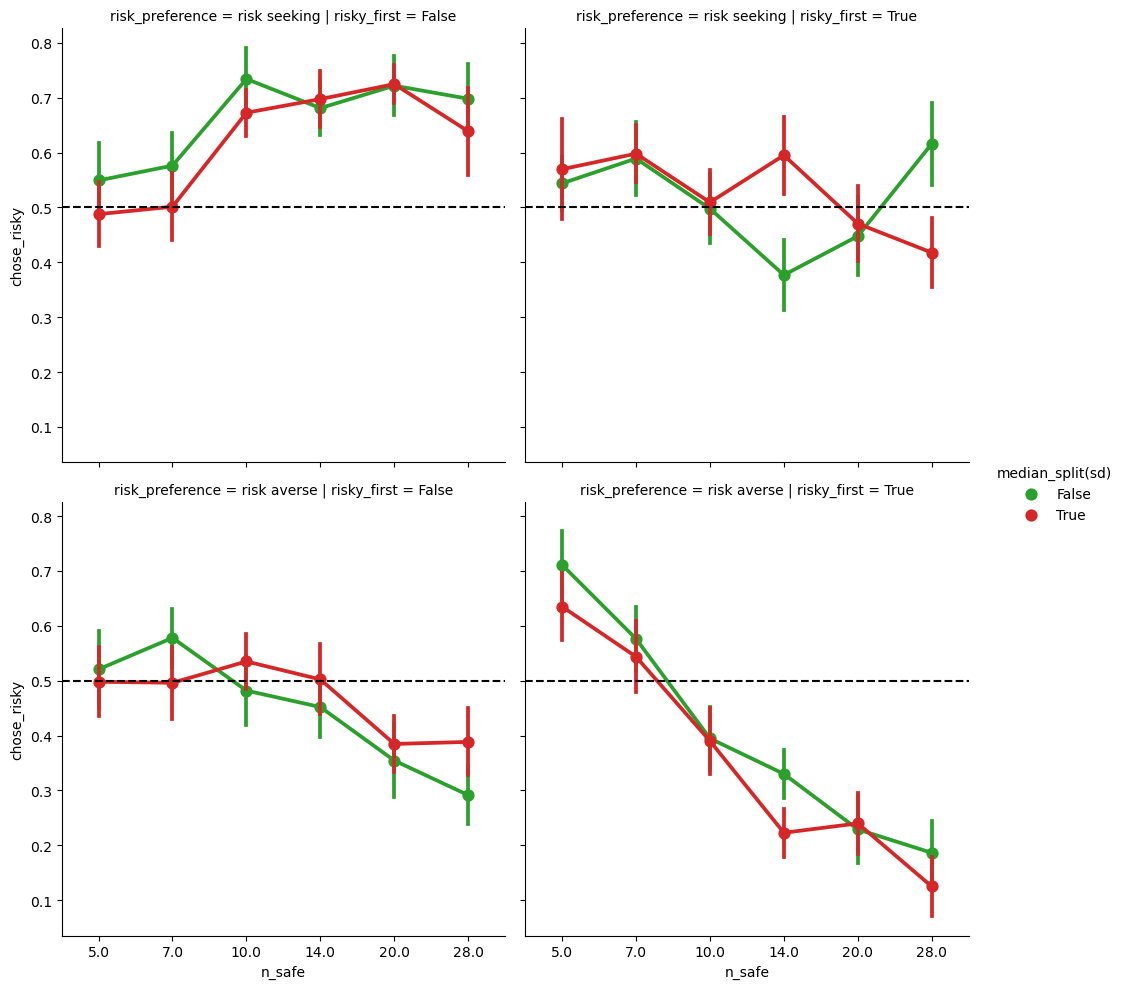

In [69]:
# fac = sns.FacetGrr
fac = sns.catplot(x='n_safe', data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(), y='chose_risky', hue='median_split(sd)',  row='risk_preference', kind='point', col='risky_first',
                  palette=sns.color_palette()[2:], errorbar='se')
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))



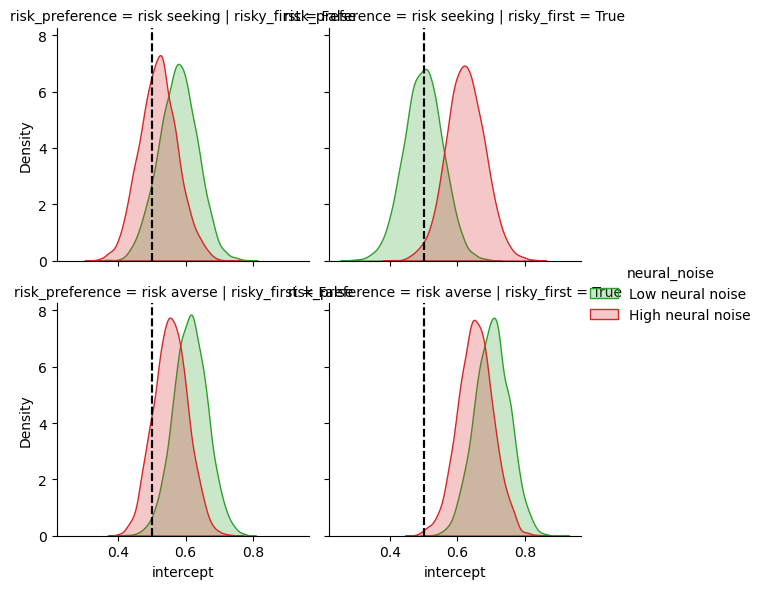

In [71]:
permutations = [[0, 1],
                d.index.get_level_values('risk_preference').unique(),
                d['neural_noise'].unique(),
                d.index.get_level_values('risky_first').unique()
                 ]
names = ['n_safe', 'risk_preference', 'neural_noise', 'risky_first']
fake_data = pd.MultiIndex.from_product(permutations, names=names).to_frame().reset_index(drop=True)
pred = model.predict(idata, 'mean', fake_data, inplace=False, include_group_specific=False)['posterior']['chose_risky_mean']
pred = pred.to_dataframe().unstack([0, 1])
pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))
intercept = pred.xs(0, 0, 'n_safe')
intercept = intercept.droplevel(0, axis=1).stack([0, 1]).to_frame('intercept')

fac = sns.FacetGrid(intercept.reset_index(), col='risky_first', hue='neural_noise', row='risk_preference', palette=sns.color_palette()[2:])
fac.map(sns.kdeplot, 'intercept', fill=True)
fac.map(lambda *args, **kwargs: plt.axvline(.5, c='k', ls='--'), 'intercept', fill=True)
fac.add_legend()

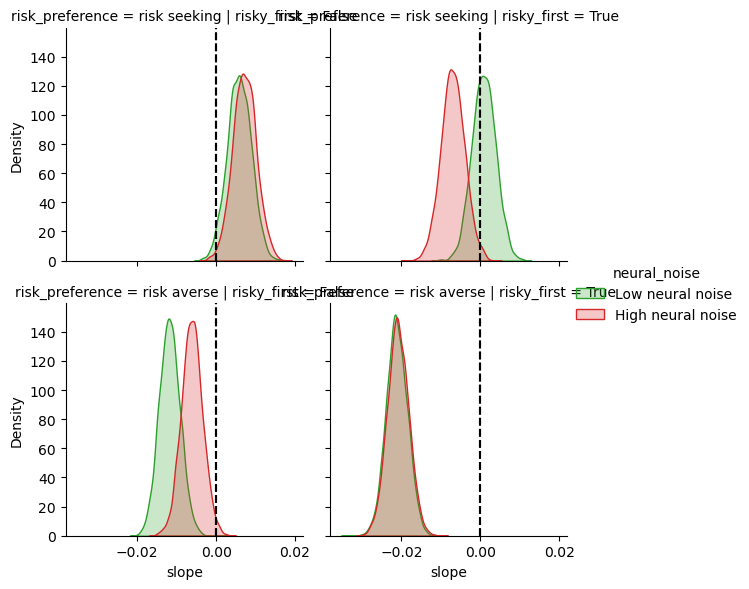

In [72]:
permutations = [[0, 1],
                d.index.get_level_values('risk_preference').unique(),
                d['neural_noise'].unique(),
                d.index.get_level_values('risky_first').unique()
                 ]
names = ['n_safe', 'risk_preference', 'neural_noise', 'risky_first']
fake_data = pd.MultiIndex.from_product(permutations, names=names).to_frame().reset_index(drop=True)
pred = model.predict(idata, 'mean', fake_data, inplace=False, include_group_specific=False)['posterior']['chose_risky_mean']
pred = pred.to_dataframe().unstack([0, 1])
pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))
intercept = pred.xs(0, 0, 'n_safe')
slope = pred.xs(1, 0, 'n_safe') - intercept
slope = slope.droplevel(0, axis=1).stack([0, 1]).to_frame('slope')


fac = sns.FacetGrid(slope.reset_index(), col='risky_first', hue='neural_noise', row='risk_preference', palette=sns.color_palette()[2:])
fac.map(sns.kdeplot, 'slope', fill=True)
fac.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))
fac.add_legend()

In [73]:
tmp = slope.loc[('risk averse', 'High neural noise', False), :] - slope.loc[('risk averse', 'Low neural noise', False), :]
(tmp > 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_54449/1592847646.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp = slope.loc[('risk averse', 'High neural noise', False), :] - slope.loc[('risk averse', 'Low neural noise', False), :]


slope    0.9335
dtype: float64

In [74]:
tmp = slope.loc[('risk seeking', 'High neural noise', True), :] - slope.loc[('risk seeking', 'Low neural noise', True), :]
(tmp > 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_54449/2841896772.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp = slope.loc[('risk seeking', 'High neural noise', True), :] - slope.loc[('risk seeking', 'Low neural noise', True), :]


slope    0.03325
dtype: float64

In [57]:
# 7T

In [63]:
model_label = 'probit_neural1'
session = '7t2'
bids_folder = '/data/ds-risk'
roi = 'npcr'

In [64]:
data = get_data(model_label, session, bids_folder, roi)
rnp = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'gamma_rnp_simple.tsv'), sep='\t', index_col=[0,1], dtype={'subject':str})[['rnp']]
rnp['risk_preference'] = (rnp['rnp'] > 0.55).map({True:'risk seeking', False:'risk averse'})
data = data.join(rnp.loc[session])

d = data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean()
d['neural_noise'] = d.index.get_level_values('median_split(sd)').map({True: 'High neural noise', False:'Low neural noise'})

model = bambi.Model('chose_risky ~ n_safe*neural_noise*risk_preference*risky_first + (1|subject)', data=d.reset_index())
idata = model.fit()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_54449/1495862042.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fac = sns.catplot(x='n_safe', data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(), y='chose_risky', hue='median_split(sd)',  row='risk_preference', kind='point', col='risky_first',


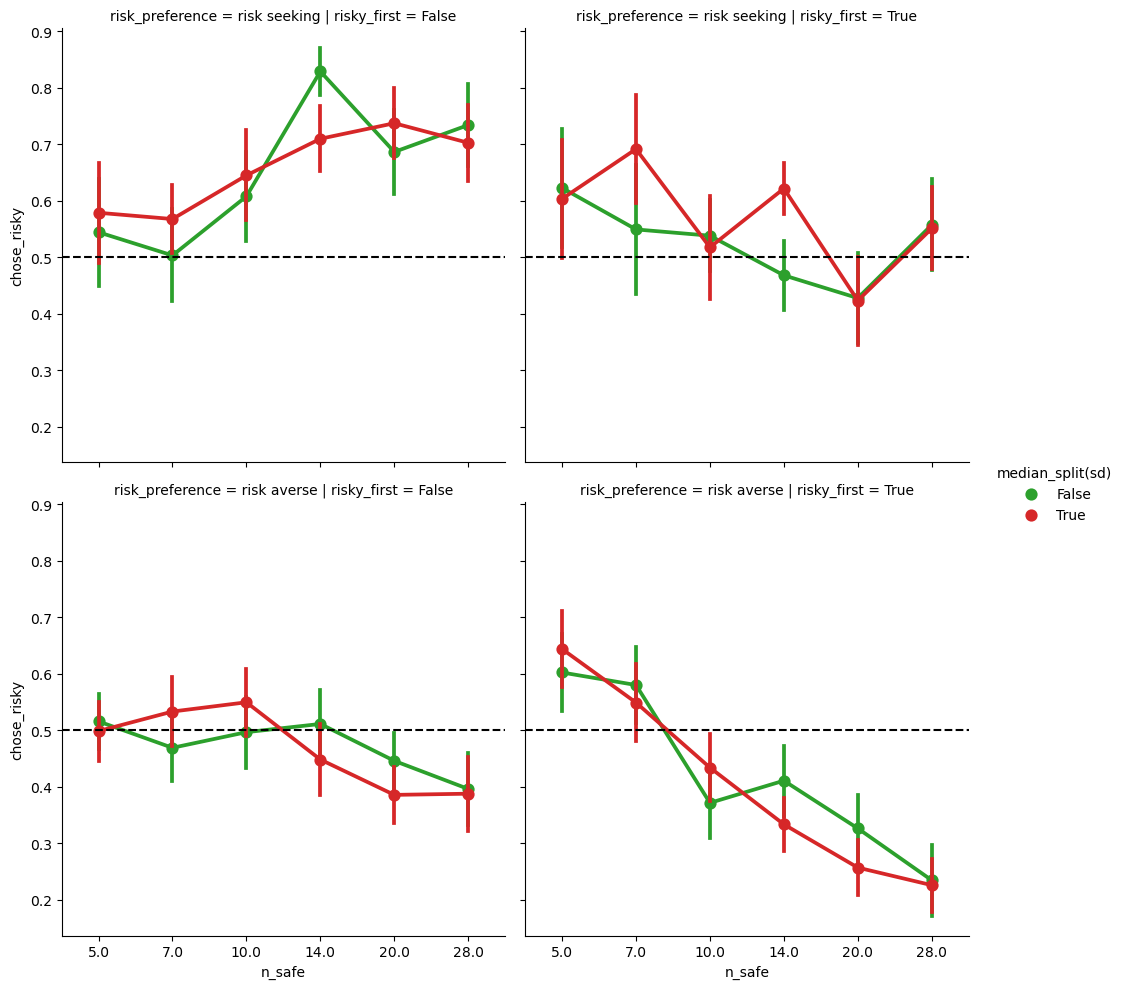

In [65]:
# fac = sns.FacetGrr
fac = sns.catplot(x='n_safe', data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(), y='chose_risky', hue='median_split(sd)',  row='risk_preference', kind='point', col='risky_first',
                  palette=sns.color_palette()[2:], errorbar='se')
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))



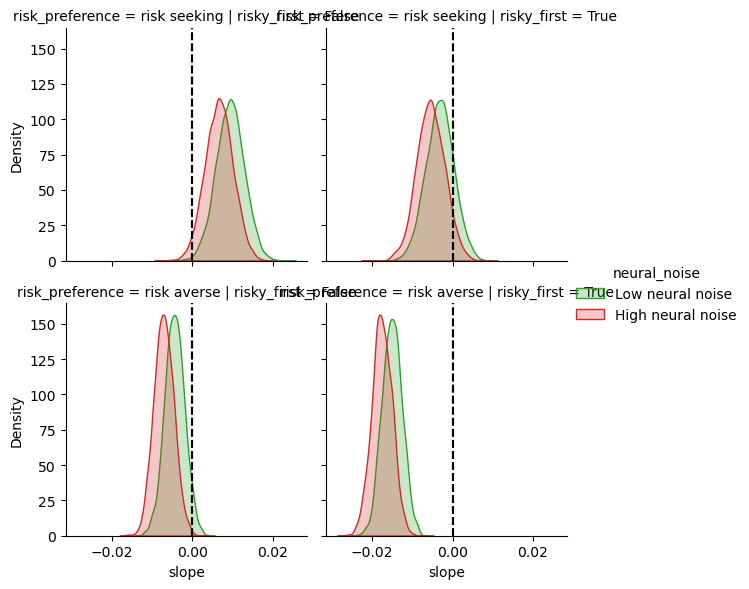

In [66]:
permutations = [[0, 1],
                d.index.get_level_values('risk_preference').unique(),
                d['neural_noise'].unique(),
                d.index.get_level_values('risky_first').unique()
                 ]
names = ['n_safe', 'risk_preference', 'neural_noise', 'risky_first']
fake_data = pd.MultiIndex.from_product(permutations, names=names).to_frame().reset_index(drop=True)
pred = model.predict(idata, 'mean', fake_data, inplace=False, include_group_specific=False)['posterior']['chose_risky_mean']
pred = pred.to_dataframe().unstack([0, 1])
pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))
intercept = pred.xs(0, 0, 'n_safe')
slope = pred.xs(1, 0, 'n_safe') - intercept
slope = slope.droplevel(0, axis=1).stack([0, 1]).to_frame('slope')


fac = sns.FacetGrid(slope.reset_index(), col='risky_first', hue='neural_noise', row='risk_preference', palette=sns.color_palette()[2:])
fac.map(sns.kdeplot, 'slope', fill=True)
fac.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))
fac.add_legend()